# Train model based on VGGish features

__VGGish__: 128-dimensional audio features extracted at 1Hz. The audio features were extracted using a VGG-inspired acoustic model described in Hershey et. al., trained on a preliminary version of YouTube-8M. The features were PCA-ed and quantized to be compatible with the audio features provided with YouTube-8M. They are stored as TensorFlow Record files.

To my understanding: VGGish model turns audio classification problems into image classification problems. They create 2D image-like patches by computing log-mel spectrograms of multiple frames, and feed that into models. The input thus become some transformations of visual representation of spectrum of frequencies of the signal as it changes with time.

Reference: https://arxiv.org/pdf/1609.09430.pdf

__PCA__: Two primary reasons for use
- Data reduction: condense the information contained in a large number of original variables into a smaller set of new composite dimensions, with a minimum loss of information.
- Interpretation: discover important features of a large data set that often reveals relationships that were previously unsuspected, thereby allowing interpretations that would not ordinarily result.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# The directory should be arranged in form:
# .
# ├── audioset_v1_embeddings
# ├── class_labels_indices.csv
# └── Model_on_VGG.ipynb

path = "audioset_v1_embeddings/"
eva = "eval/"
bal = "bal_train/"
unbal = "unbal_train/"

In [3]:
index_label = pd.read_csv("class_labels_indices.csv")

In [4]:
def map_index_to_label(index_label, index):
    # Maps index to readable labels
    # Return label is a list, that could contain more than 1 item, but refer to the same label
    # Return labels are all in lower form, no CAP
    # e.g. ['male speech', 'man speaking']
    #
    # input: pandas.DataFrame index_to_label_df, int index
    # output: list readable_label
    
    # Get the real index of df, in case of mismatch
    index = index_label.loc[index_label['index'] == index].index[0] 
    labels = [label.strip().lower() for label in index_label.iloc[index]['display_name'].split(",")]
    return labels

In [5]:
def map_label_to_index(index_label, label):
    # Maps readable labels to index
    #
    # input: pandas.DataFrame index_to_label_df, str label
    # output: int index
    label = label.lower()
    labelCap = label.capitalize()
    for index, row in index_label.iterrows():
        labels = [label.strip() for label in row['display_name'].split(",")]
        if label in labels or labelCap in labels:
            return index_label.iloc[index]['index']
    return -1

In [20]:
def read_tfrecord(filename):
    # Read in a tfrecord file
    # Store information in list of lists
    #
    # input: str filename
    # output: pandas dataframe with columns:
    #        [str video_id, float start_time, float end_time, list label_index, list embed]
    
    if not filename.endswith('.tfrecord'):
        print("This file is not a .tfrecord file.")
        return
    raw_dataset = tf.data.TFRecordDataset(filename)
    return_df = pd.DataFrame(columns=
                             ['video_id', 'start_time_seconds', 'end_time_seconds', 'labels', 'audio_embedding'])
    for raw_record in raw_dataset:
        cur_record_list = []
        example = tf.train.SequenceExample()
        example.ParseFromString(raw_record.numpy())
        
        cur_record_list.append(example.context.feature['video_id'].bytes_list.value[0].decode("utf-8"))
        cur_record_list.append(example.context.feature['start_time_seconds'].float_list.value[0])
        cur_record_list.append(example.context.feature['end_time_seconds'].float_list.value[0])
        cur_record_list.append(example.context.feature['labels'].int64_list.value)
        
        # Original embeddings are stored in hex format, now convert them to readable int
        hexembed = example.feature_lists.feature_list['audio_embedding'].feature[0].bytes_list.value[0].hex()
        arrayembed = [int(hexembed[i:i+2], 16) for i in range(0, len(hexembed), 2)]
        cur_record_list.append(arrayembed)
        
        return_df.loc[len(return_df)] = cur_record_list
    return return_df

In [29]:
def convert_csv_tfrecord_dir(dir_path, dest):
    # Read and concat all tfrecord files in a directory
    # and save to csv in appending mode
    #
    # input: str directory_path, (must contain '/' in the end, e.g. 'unbal_train/')
    # output: int count_tfrecord_files
    cnt = 0
    for file in os.listdir(dir_path):
        if file.endswith(".tfrecord"):
            print(str(cnt) + ". " + file + ": start")
            df = read_tfrecord(dir_path+file)
            # Original method, that read all data into a df, then store it as csv
            # takes too much RAM, and causes crashes when reach limit
            # Now update to batch save to avoid exploding uses of RAM
            # But still, CPU usage is too high, hope to upgrade later
            if cnt == 0:
                df.to_csv(dir_path+dest, index=False, header=True)
            else:
                df.to_csv(dir_path+dest, mode='a', index=False, header=False)
            print(str(cnt) + ". " + file + ": end")
            cnt += 1
    return cnt

In [12]:
convert_csv_tfrecord_dir(path+eva, 'eva.csv')

4062

In [15]:
convert_csv_tfrecord_dir(path+bal, 'bal_train.csv')

4070

In [30]:
# Takes a looooooooooong time!
convert_csv_tfrecord_dir(path+unbal, 'unbal_train.csv')

0. W8.tfrecord: start
0. W8.tfrecord: end
1. L3.tfrecord: start
1. L3.tfrecord: end
2. KO.tfrecord: start
2. KO.tfrecord: end
3. xt.tfrecord: start
3. xt.tfrecord: end
4. Ul.tfrecord: start
4. Ul.tfrecord: end
5. 2T.tfrecord: start
5. 2T.tfrecord: end
6. bC.tfrecord: start
6. bC.tfrecord: end
7. sG.tfrecord: start
7. sG.tfrecord: end
8. JB.tfrecord: start
8. JB.tfrecord: end
9. oU.tfrecord: start
9. oU.tfrecord: end
10. D1.tfrecord: start
10. D1.tfrecord: end
11. ph.tfrecord: start
11. ph.tfrecord: end
12. qA.tfrecord: start
12. qA.tfrecord: end
13. 1v.tfrecord: start
13. 1v.tfrecord: end
14. Vu.tfrecord: start
14. Vu.tfrecord: end
15. 70.tfrecord: start
15. 70.tfrecord: end
16. mV.tfrecord: start
16. mV.tfrecord: end
17. aK.tfrecord: start
17. aK.tfrecord: end
18. Ph.tfrecord: start
18. Ph.tfrecord: end
19. is.tfrecord: start
19. is.tfrecord: end
20. ka.tfrecord: start
20. ka.tfrecord: end
21. Jk.tfrecord: start
21. Jk.tfrecord: end
22. e0.tfrecord: start
22. e0.tfrecord: end
23. 22.t

183. 7v.tfrecord: end
184. 5w.tfrecord: start
184. 5w.tfrecord: end
185. HS.tfrecord: start
185. HS.tfrecord: end
186. 6Z.tfrecord: start
186. 6Z.tfrecord: end
187. Li.tfrecord: start
187. Li.tfrecord: end
188. kr.tfrecord: start
188. kr.tfrecord: end
189. iZ.tfrecord: start
189. iZ.tfrecord: end
190. VP.tfrecord: start
190. VP.tfrecord: end
191. H0.tfrecord: start
191. H0.tfrecord: end
192. wD.tfrecord: start
192. wD.tfrecord: end
193. pU.tfrecord: start
193. pU.tfrecord: end
194. vP.tfrecord: start
194. vP.tfrecord: end
195. EG.tfrecord: start
195. EG.tfrecord: end
196. 5C.tfrecord: start
196. 5C.tfrecord: end
197. df.tfrecord: start
197. df.tfrecord: end
198. kS.tfrecord: start
198. kS.tfrecord: end
199. dC.tfrecord: start
199. dC.tfrecord: end
200. NR.tfrecord: start
200. NR.tfrecord: end
201. MO.tfrecord: start
201. MO.tfrecord: end
202. Ky.tfrecord: start
202. Ky.tfrecord: end
203. sd.tfrecord: start
203. sd.tfrecord: end
204. 10.tfrecord: start
204. 10.tfrecord: end
205. ST.tfre

362. yO.tfrecord: end
363. Ig.tfrecord: start
363. Ig.tfrecord: end
364. Nw.tfrecord: start
364. Nw.tfrecord: end
365. RU.tfrecord: start
365. RU.tfrecord: end
366. xI.tfrecord: start
366. xI.tfrecord: end
367. SI.tfrecord: start
367. SI.tfrecord: end
368. V5.tfrecord: start
368. V5.tfrecord: end
369. mf.tfrecord: start
369. mf.tfrecord: end
370. Xs.tfrecord: start
370. Xs.tfrecord: end
371. NX.tfrecord: start
371. NX.tfrecord: end
372. 8N.tfrecord: start
372. 8N.tfrecord: end
373. I8.tfrecord: start
373. I8.tfrecord: end
374. jc.tfrecord: start
374. jc.tfrecord: end
375. YT.tfrecord: start
375. YT.tfrecord: end
376. 97.tfrecord: start
376. 97.tfrecord: end
377. Bk.tfrecord: start
377. Bk.tfrecord: end
378. 8Y.tfrecord: start
378. 8Y.tfrecord: end
379. ub.tfrecord: start
379. ub.tfrecord: end
380. gF.tfrecord: start
380. gF.tfrecord: end
381. SF.tfrecord: start
381. SF.tfrecord: end
382. Oh.tfrecord: start
382. Oh.tfrecord: end
383. ce.tfrecord: start
383. ce.tfrecord: end
384. uw.tfre

541. 9V.tfrecord: end
542. X8.tfrecord: start
542. X8.tfrecord: end
543. 6G.tfrecord: start
543. 6G.tfrecord: end
544. hg.tfrecord: start
544. hg.tfrecord: end
545. uv.tfrecord: start
545. uv.tfrecord: end
546. pv.tfrecord: start
546. pv.tfrecord: end
547. sk.tfrecord: start
547. sk.tfrecord: end
548. v2.tfrecord: start
548. v2.tfrecord: end
549. 2N.tfrecord: start
549. 2N.tfrecord: end
550. IE.tfrecord: start
550. IE.tfrecord: end
551. vI.tfrecord: start
551. vI.tfrecord: end
552. 1G.tfrecord: start
552. 1G.tfrecord: end
553. 4-.tfrecord: start
553. 4-.tfrecord: end
554. wn.tfrecord: start
554. wn.tfrecord: end
555. hL.tfrecord: start
555. hL.tfrecord: end
556. 8l.tfrecord: start
556. 8l.tfrecord: end
557. 3i.tfrecord: start
557. 3i.tfrecord: end
558. IS.tfrecord: start
558. IS.tfrecord: end
559. 87.tfrecord: start
559. 87.tfrecord: end
560. jj.tfrecord: start
560. jj.tfrecord: end
561. lK.tfrecord: start
561. lK.tfrecord: end
562. _C.tfrecord: start
562. _C.tfrecord: end
563. R_.tfre

720. iV.tfrecord: end
721. Yi.tfrecord: start
721. Yi.tfrecord: end
722. oZ.tfrecord: start
722. oZ.tfrecord: end
723. oY.tfrecord: start
723. oY.tfrecord: end
724. We.tfrecord: start
724. We.tfrecord: end
725. RO.tfrecord: start
725. RO.tfrecord: end
726. 9o.tfrecord: start
726. 9o.tfrecord: end
727. -D.tfrecord: start
727. -D.tfrecord: end
728. Gl.tfrecord: start
728. Gl.tfrecord: end
729. hq.tfrecord: start
729. hq.tfrecord: end
730. 0J.tfrecord: start
730. 0J.tfrecord: end
731. Tn.tfrecord: start
731. Tn.tfrecord: end
732. 6V.tfrecord: start
732. 6V.tfrecord: end
733. hS.tfrecord: start
733. hS.tfrecord: end
734. 4r.tfrecord: start
734. 4r.tfrecord: end
735. YC.tfrecord: start
735. YC.tfrecord: end
736. pK.tfrecord: start
736. pK.tfrecord: end
737. bE.tfrecord: start
737. bE.tfrecord: end
738. 15.tfrecord: start
738. 15.tfrecord: end
739. G3.tfrecord: start
739. G3.tfrecord: end
740. ax.tfrecord: start
740. ax.tfrecord: end
741. SX.tfrecord: start
741. SX.tfrecord: end
742. Ub.tfre

899. EZ.tfrecord: end
900. 6l.tfrecord: start
900. 6l.tfrecord: end
901. Yt.tfrecord: start
901. Yt.tfrecord: end
902. 5X.tfrecord: start
902. 5X.tfrecord: end
903. cE.tfrecord: start
903. cE.tfrecord: end
904. wY.tfrecord: start
904. wY.tfrecord: end
905. PH.tfrecord: start
905. PH.tfrecord: end
906. hl.tfrecord: start
906. hl.tfrecord: end
907. Ev.tfrecord: start
907. Ev.tfrecord: end
908. NT.tfrecord: start
908. NT.tfrecord: end
909. mD.tfrecord: start
909. mD.tfrecord: end
910. fj.tfrecord: start
910. fj.tfrecord: end
911. tl.tfrecord: start
911. tl.tfrecord: end
912. nK.tfrecord: start
912. nK.tfrecord: end
913. Uy.tfrecord: start
913. Uy.tfrecord: end
914. by.tfrecord: start
914. by.tfrecord: end
915. B4.tfrecord: start
915. B4.tfrecord: end
916. OZ.tfrecord: start
916. OZ.tfrecord: end
917. Ny.tfrecord: start
917. Ny.tfrecord: end
918. d1.tfrecord: start
918. d1.tfrecord: end
919. BT.tfrecord: start
919. BT.tfrecord: end
920. Uo.tfrecord: start
920. Uo.tfrecord: end
921. GJ.tfre

1074. Kb.tfrecord: end
1075. ty.tfrecord: start
1075. ty.tfrecord: end
1076. 1t.tfrecord: start
1076. 1t.tfrecord: end
1077. 8h.tfrecord: start
1077. 8h.tfrecord: end
1078. XN.tfrecord: start
1078. XN.tfrecord: end
1079. 1y.tfrecord: start
1079. 1y.tfrecord: end
1080. LO.tfrecord: start
1080. LO.tfrecord: end
1081. pE.tfrecord: start
1081. pE.tfrecord: end
1082. oo.tfrecord: start
1082. oo.tfrecord: end
1083. Xc.tfrecord: start
1083. Xc.tfrecord: end
1084. Gj.tfrecord: start
1084. Gj.tfrecord: end
1085. F9.tfrecord: start
1085. F9.tfrecord: end
1086. U1.tfrecord: start
1086. U1.tfrecord: end
1087. Y5.tfrecord: start
1087. Y5.tfrecord: end
1088. A-.tfrecord: start
1088. A-.tfrecord: end
1089. ja.tfrecord: start
1089. ja.tfrecord: end
1090. rU.tfrecord: start
1090. rU.tfrecord: end
1091. 7U.tfrecord: start
1091. 7U.tfrecord: end
1092. qi.tfrecord: start
1092. qi.tfrecord: end
1093. An.tfrecord: start
1093. An.tfrecord: end
1094. rY.tfrecord: start
1094. rY.tfrecord: end
1095. JZ.tfrecord

1245. Jw.tfrecord: end
1246. uI.tfrecord: start
1246. uI.tfrecord: end
1247. rl.tfrecord: start
1247. rl.tfrecord: end
1248. Yq.tfrecord: start
1248. Yq.tfrecord: end
1249. LC.tfrecord: start
1249. LC.tfrecord: end
1250. ly.tfrecord: start
1250. ly.tfrecord: end
1251. jO.tfrecord: start
1251. jO.tfrecord: end
1252. VH.tfrecord: start
1252. VH.tfrecord: end
1253. uY.tfrecord: start
1253. uY.tfrecord: end
1254. 0v.tfrecord: start
1254. 0v.tfrecord: end
1255. ZG.tfrecord: start
1255. ZG.tfrecord: end
1256. u_.tfrecord: start
1256. u_.tfrecord: end
1257. tH.tfrecord: start
1257. tH.tfrecord: end
1258. Wb.tfrecord: start
1258. Wb.tfrecord: end
1259. SA.tfrecord: start
1259. SA.tfrecord: end
1260. s4.tfrecord: start
1260. s4.tfrecord: end
1261. mc.tfrecord: start
1261. mc.tfrecord: end
1262. n4.tfrecord: start
1262. n4.tfrecord: end
1263. jp.tfrecord: start
1263. jp.tfrecord: end
1264. _Q.tfrecord: start
1264. _Q.tfrecord: end
1265. Ct.tfrecord: start
1265. Ct.tfrecord: end
1266. aU.tfrecord

1416. wd.tfrecord: end
1417. m6.tfrecord: start
1417. m6.tfrecord: end
1418. Kf.tfrecord: start
1418. Kf.tfrecord: end
1419. Bs.tfrecord: start
1419. Bs.tfrecord: end
1420. Wc.tfrecord: start
1420. Wc.tfrecord: end
1421. -V.tfrecord: start
1421. -V.tfrecord: end
1422. _b.tfrecord: start
1422. _b.tfrecord: end
1423. r-.tfrecord: start
1423. r-.tfrecord: end
1424. n8.tfrecord: start
1424. n8.tfrecord: end
1425. U_.tfrecord: start
1425. U_.tfrecord: end
1426. 0b.tfrecord: start
1426. 0b.tfrecord: end
1427. el.tfrecord: start
1427. el.tfrecord: end
1428. mA.tfrecord: start
1428. mA.tfrecord: end
1429. CY.tfrecord: start
1429. CY.tfrecord: end
1430. 3q.tfrecord: start
1430. 3q.tfrecord: end
1431. pF.tfrecord: start
1431. pF.tfrecord: end
1432. hM.tfrecord: start
1432. hM.tfrecord: end
1433. 7H.tfrecord: start
1433. 7H.tfrecord: end
1434. s_.tfrecord: start
1434. s_.tfrecord: end
1435. 6T.tfrecord: start
1435. 6T.tfrecord: end
1436. yg.tfrecord: start
1436. yg.tfrecord: end
1437. CA.tfrecord

1587. ls.tfrecord: end
1588. Rt.tfrecord: start
1588. Rt.tfrecord: end
1589. qg.tfrecord: start
1589. qg.tfrecord: end
1590. Qa.tfrecord: start
1590. Qa.tfrecord: end
1591. zB.tfrecord: start
1591. zB.tfrecord: end
1592. _S.tfrecord: start
1592. _S.tfrecord: end
1593. yY.tfrecord: start
1593. yY.tfrecord: end
1594. 3J.tfrecord: start
1594. 3J.tfrecord: end
1595. AS.tfrecord: start
1595. AS.tfrecord: end
1596. 25.tfrecord: start
1596. 25.tfrecord: end
1597. r9.tfrecord: start
1597. r9.tfrecord: end
1598. OD.tfrecord: start
1598. OD.tfrecord: end
1599. lQ.tfrecord: start
1599. lQ.tfrecord: end
1600. 9L.tfrecord: start
1600. 9L.tfrecord: end
1601. vU.tfrecord: start
1601. vU.tfrecord: end
1602. iu.tfrecord: start
1602. iu.tfrecord: end
1603. Me.tfrecord: start
1603. Me.tfrecord: end
1604. 4s.tfrecord: start
1604. 4s.tfrecord: end
1605. CM.tfrecord: start
1605. CM.tfrecord: end
1606. k0.tfrecord: start
1606. k0.tfrecord: end
1607. V_.tfrecord: start
1607. V_.tfrecord: end
1608. J6.tfrecord

1758. WK.tfrecord: end
1759. xx.tfrecord: start
1759. xx.tfrecord: end
1760. PG.tfrecord: start
1760. PG.tfrecord: end
1761. aj.tfrecord: start
1761. aj.tfrecord: end
1762. mr.tfrecord: start
1762. mr.tfrecord: end
1763. cu.tfrecord: start
1763. cu.tfrecord: end
1764. UC.tfrecord: start
1764. UC.tfrecord: end
1765. WU.tfrecord: start
1765. WU.tfrecord: end
1766. Bg.tfrecord: start
1766. Bg.tfrecord: end
1767. _v.tfrecord: start
1767. _v.tfrecord: end
1768. Jr.tfrecord: start
1768. Jr.tfrecord: end
1769. Im.tfrecord: start
1769. Im.tfrecord: end
1770. 4t.tfrecord: start
1770. 4t.tfrecord: end
1771. 0W.tfrecord: start
1771. 0W.tfrecord: end
1772. k6.tfrecord: start
1772. k6.tfrecord: end
1773. h2.tfrecord: start
1773. h2.tfrecord: end
1774. Bc.tfrecord: start
1774. Bc.tfrecord: end
1775. Dw.tfrecord: start
1775. Dw.tfrecord: end
1776. UT.tfrecord: start
1776. UT.tfrecord: end
1777. gP.tfrecord: start
1777. gP.tfrecord: end
1778. B6.tfrecord: start
1778. B6.tfrecord: end
1779. mq.tfrecord

1929. p3.tfrecord: end
1930. cp.tfrecord: start
1930. cp.tfrecord: end
1931. Bz.tfrecord: start
1931. Bz.tfrecord: end
1932. 2b.tfrecord: start
1932. 2b.tfrecord: end
1933. X0.tfrecord: start
1933. X0.tfrecord: end
1934. 9f.tfrecord: start
1934. 9f.tfrecord: end
1935. au.tfrecord: start
1935. au.tfrecord: end
1936. _f.tfrecord: start
1936. _f.tfrecord: end
1937. Ty.tfrecord: start
1937. Ty.tfrecord: end
1938. -b.tfrecord: start
1938. -b.tfrecord: end
1939. 3t.tfrecord: start
1939. 3t.tfrecord: end
1940. Rx.tfrecord: start
1940. Rx.tfrecord: end
1941. 7k.tfrecord: start
1941. 7k.tfrecord: end
1942. tu.tfrecord: start
1942. tu.tfrecord: end
1943. gB.tfrecord: start
1943. gB.tfrecord: end
1944. U6.tfrecord: start
1944. U6.tfrecord: end
1945. 8-.tfrecord: start
1945. 8-.tfrecord: end
1946. aP.tfrecord: start
1946. aP.tfrecord: end
1947. Rk.tfrecord: start
1947. Rk.tfrecord: end
1948. WR.tfrecord: start
1948. WR.tfrecord: end
1949. ej.tfrecord: start
1949. ej.tfrecord: end
1950. P0.tfrecord

2100. hB.tfrecord: end
2101. 5-.tfrecord: start
2101. 5-.tfrecord: end
2102. vr.tfrecord: start
2102. vr.tfrecord: end
2103. FC.tfrecord: start
2103. FC.tfrecord: end
2104. vE.tfrecord: start
2104. vE.tfrecord: end
2105. u4.tfrecord: start
2105. u4.tfrecord: end
2106. -h.tfrecord: start
2106. -h.tfrecord: end
2107. 33.tfrecord: start
2107. 33.tfrecord: end
2108. PU.tfrecord: start
2108. PU.tfrecord: end
2109. c5.tfrecord: start
2109. c5.tfrecord: end
2110. r3.tfrecord: start
2110. r3.tfrecord: end
2111. 6o.tfrecord: start
2111. 6o.tfrecord: end
2112. 7A.tfrecord: start
2112. 7A.tfrecord: end
2113. jE.tfrecord: start
2113. jE.tfrecord: end
2114. dk.tfrecord: start
2114. dk.tfrecord: end
2115. yQ.tfrecord: start
2115. yQ.tfrecord: end
2116. 2o.tfrecord: start
2116. 2o.tfrecord: end
2117. 6B.tfrecord: start
2117. 6B.tfrecord: end
2118. Jq.tfrecord: start
2118. Jq.tfrecord: end
2119. 2X.tfrecord: start
2119. 2X.tfrecord: end
2120. xy.tfrecord: start
2120. xy.tfrecord: end
2121. kA.tfrecord

2271. hT.tfrecord: end
2272. 3w.tfrecord: start
2272. 3w.tfrecord: end
2273. Ut.tfrecord: start
2273. Ut.tfrecord: end
2274. C0.tfrecord: start
2274. C0.tfrecord: end
2275. W1.tfrecord: start
2275. W1.tfrecord: end
2276. bK.tfrecord: start
2276. bK.tfrecord: end
2277. l4.tfrecord: start
2277. l4.tfrecord: end
2278. 8z.tfrecord: start
2278. 8z.tfrecord: end
2279. dv.tfrecord: start
2279. dv.tfrecord: end
2280. h1.tfrecord: start
2280. h1.tfrecord: end
2281. 7J.tfrecord: start
2281. 7J.tfrecord: end
2282. W7.tfrecord: start
2282. W7.tfrecord: end
2283. jG.tfrecord: start
2283. jG.tfrecord: end
2284. aB.tfrecord: start
2284. aB.tfrecord: end
2285. GC.tfrecord: start
2285. GC.tfrecord: end
2286. bc.tfrecord: start
2286. bc.tfrecord: end
2287. t9.tfrecord: start
2287. t9.tfrecord: end
2288. qV.tfrecord: start
2288. qV.tfrecord: end
2289. 8B.tfrecord: start
2289. 8B.tfrecord: end
2290. wA.tfrecord: start
2290. wA.tfrecord: end
2291. 2i.tfrecord: start
2291. 2i.tfrecord: end
2292. Sa.tfrecord

2442. cG.tfrecord: end
2443. hn.tfrecord: start
2443. hn.tfrecord: end
2444. Ez.tfrecord: start
2444. Ez.tfrecord: end
2445. 3v.tfrecord: start
2445. 3v.tfrecord: end
2446. TX.tfrecord: start
2446. TX.tfrecord: end
2447. K4.tfrecord: start
2447. K4.tfrecord: end
2448. CH.tfrecord: start
2448. CH.tfrecord: end
2449. H8.tfrecord: start
2449. H8.tfrecord: end
2450. yd.tfrecord: start
2450. yd.tfrecord: end
2451. Bp.tfrecord: start
2451. Bp.tfrecord: end
2452. Q5.tfrecord: start
2452. Q5.tfrecord: end
2453. MD.tfrecord: start
2453. MD.tfrecord: end
2454. yl.tfrecord: start
2454. yl.tfrecord: end
2455. Lu.tfrecord: start
2455. Lu.tfrecord: end
2456. bP.tfrecord: start
2456. bP.tfrecord: end
2457. 3j.tfrecord: start
2457. 3j.tfrecord: end
2458. VU.tfrecord: start
2458. VU.tfrecord: end
2459. eQ.tfrecord: start
2459. eQ.tfrecord: end
2460. 8X.tfrecord: start
2460. 8X.tfrecord: end
2461. hP.tfrecord: start
2461. hP.tfrecord: end
2462. Ji.tfrecord: start
2462. Ji.tfrecord: end
2463. dT.tfrecord

2613. oS.tfrecord: end
2614. _4.tfrecord: start
2614. _4.tfrecord: end
2615. Cy.tfrecord: start
2615. Cy.tfrecord: end
2616. 45.tfrecord: start
2616. 45.tfrecord: end
2617. Fa.tfrecord: start
2617. Fa.tfrecord: end
2618. qF.tfrecord: start
2618. qF.tfrecord: end
2619. 3P.tfrecord: start
2619. 3P.tfrecord: end
2620. 0o.tfrecord: start
2620. 0o.tfrecord: end
2621. 8o.tfrecord: start
2621. 8o.tfrecord: end
2622. vC.tfrecord: start
2622. vC.tfrecord: end
2623. ri.tfrecord: start
2623. ri.tfrecord: end
2624. jy.tfrecord: start
2624. jy.tfrecord: end
2625. lh.tfrecord: start
2625. lh.tfrecord: end
2626. Tr.tfrecord: start
2626. Tr.tfrecord: end
2627. Jh.tfrecord: start
2627. Jh.tfrecord: end
2628. 6J.tfrecord: start
2628. 6J.tfrecord: end
2629. HC.tfrecord: start
2629. HC.tfrecord: end
2630. Rd.tfrecord: start
2630. Rd.tfrecord: end
2631. F1.tfrecord: start
2631. F1.tfrecord: end
2632. mC.tfrecord: start
2632. mC.tfrecord: end
2633. de.tfrecord: start
2633. de.tfrecord: end
2634. -S.tfrecord

2784. 3E.tfrecord: end
2785. Qn.tfrecord: start
2785. Qn.tfrecord: end
2786. PX.tfrecord: start
2786. PX.tfrecord: end
2787. ef.tfrecord: start
2787. ef.tfrecord: end
2788. 2t.tfrecord: start
2788. 2t.tfrecord: end
2789. v8.tfrecord: start
2789. v8.tfrecord: end
2790. mR.tfrecord: start
2790. mR.tfrecord: end
2791. J3.tfrecord: start
2791. J3.tfrecord: end
2792. uF.tfrecord: start
2792. uF.tfrecord: end
2793. MU.tfrecord: start
2793. MU.tfrecord: end
2794. OX.tfrecord: start
2794. OX.tfrecord: end
2795. G8.tfrecord: start
2795. G8.tfrecord: end
2796. sb.tfrecord: start
2796. sb.tfrecord: end
2797. qQ.tfrecord: start
2797. qQ.tfrecord: end
2798. JA.tfrecord: start
2798. JA.tfrecord: end
2799. sD.tfrecord: start
2799. sD.tfrecord: end
2800. mo.tfrecord: start
2800. mo.tfrecord: end
2801. i2.tfrecord: start
2801. i2.tfrecord: end
2802. s5.tfrecord: start
2802. s5.tfrecord: end
2803. T1.tfrecord: start
2803. T1.tfrecord: end
2804. g8.tfrecord: start
2804. g8.tfrecord: end
2805. Wn.tfrecord

2955. Gt.tfrecord: end
2956. PV.tfrecord: start
2956. PV.tfrecord: end
2957. 1H.tfrecord: start
2957. 1H.tfrecord: end
2958. e8.tfrecord: start
2958. e8.tfrecord: end
2959. QO.tfrecord: start
2959. QO.tfrecord: end
2960. Ii.tfrecord: start
2960. Ii.tfrecord: end
2961. FP.tfrecord: start
2961. FP.tfrecord: end
2962. lu.tfrecord: start
2962. lu.tfrecord: end
2963. KJ.tfrecord: start
2963. KJ.tfrecord: end
2964. 1e.tfrecord: start
2964. 1e.tfrecord: end
2965. 2c.tfrecord: start
2965. 2c.tfrecord: end
2966. Ca.tfrecord: start
2966. Ca.tfrecord: end
2967. j4.tfrecord: start
2967. j4.tfrecord: end
2968. hX.tfrecord: start
2968. hX.tfrecord: end
2969. U9.tfrecord: start
2969. U9.tfrecord: end
2970. Ci.tfrecord: start
2970. Ci.tfrecord: end
2971. Hj.tfrecord: start
2971. Hj.tfrecord: end
2972. 91.tfrecord: start
2972. 91.tfrecord: end
2973. Lf.tfrecord: start
2973. Lf.tfrecord: end
2974. bF.tfrecord: start
2974. bF.tfrecord: end
2975. BS.tfrecord: start
2975. BS.tfrecord: end
2976. HI.tfrecord

3126. F4.tfrecord: end
3127. f8.tfrecord: start
3127. f8.tfrecord: end
3128. dc.tfrecord: start
3128. dc.tfrecord: end
3129. IU.tfrecord: start
3129. IU.tfrecord: end
3130. nm.tfrecord: start
3130. nm.tfrecord: end
3131. AZ.tfrecord: start
3131. AZ.tfrecord: end
3132. wl.tfrecord: start
3132. wl.tfrecord: end
3133. ow.tfrecord: start
3133. ow.tfrecord: end
3134. 4c.tfrecord: start
3134. 4c.tfrecord: end
3135. Z8.tfrecord: start
3135. Z8.tfrecord: end
3136. q5.tfrecord: start
3136. q5.tfrecord: end
3137. 9Z.tfrecord: start
3137. 9Z.tfrecord: end
3138. CL.tfrecord: start
3138. CL.tfrecord: end
3139. Xr.tfrecord: start
3139. Xr.tfrecord: end
3140. 9R.tfrecord: start
3140. 9R.tfrecord: end
3141. AK.tfrecord: start
3141. AK.tfrecord: end
3142. ee.tfrecord: start
3142. ee.tfrecord: end
3143. Ps.tfrecord: start
3143. Ps.tfrecord: end
3144. lI.tfrecord: start
3144. lI.tfrecord: end
3145. BF.tfrecord: start
3145. BF.tfrecord: end
3146. qc.tfrecord: start
3146. qc.tfrecord: end
3147. Il.tfrecord

3297. 3g.tfrecord: end
3298. Rc.tfrecord: start
3298. Rc.tfrecord: end
3299. Jg.tfrecord: start
3299. Jg.tfrecord: end
3300. Lv.tfrecord: start
3300. Lv.tfrecord: end
3301. br.tfrecord: start
3301. br.tfrecord: end
3302. le.tfrecord: start
3302. le.tfrecord: end
3303. SW.tfrecord: start
3303. SW.tfrecord: end
3304. Wf.tfrecord: start
3304. Wf.tfrecord: end
3305. dF.tfrecord: start
3305. dF.tfrecord: end
3306. cD.tfrecord: start
3306. cD.tfrecord: end
3307. Gh.tfrecord: start
3307. Gh.tfrecord: end
3308. GH.tfrecord: start
3308. GH.tfrecord: end
3309. DL.tfrecord: start
3309. DL.tfrecord: end
3310. TY.tfrecord: start
3310. TY.tfrecord: end
3311. 9Y.tfrecord: start
3311. 9Y.tfrecord: end
3312. -u.tfrecord: start
3312. -u.tfrecord: end
3313. _E.tfrecord: start
3313. _E.tfrecord: end
3314. Uq.tfrecord: start
3314. Uq.tfrecord: end
3315. VM.tfrecord: start
3315. VM.tfrecord: end
3316. w2.tfrecord: start
3316. w2.tfrecord: end
3317. j8.tfrecord: start
3317. j8.tfrecord: end
3318. nd.tfrecord

3468. FU.tfrecord: end
3469. tj.tfrecord: start
3469. tj.tfrecord: end
3470. 4d.tfrecord: start
3470. 4d.tfrecord: end
3471. 2D.tfrecord: start
3471. 2D.tfrecord: end
3472. iN.tfrecord: start
3472. iN.tfrecord: end
3473. N_.tfrecord: start
3473. N_.tfrecord: end
3474. nS.tfrecord: start
3474. nS.tfrecord: end
3475. Iq.tfrecord: start
3475. Iq.tfrecord: end
3476. j9.tfrecord: start
3476. j9.tfrecord: end
3477. nR.tfrecord: start
3477. nR.tfrecord: end
3478. PN.tfrecord: start
3478. PN.tfrecord: end
3479. c8.tfrecord: start
3479. c8.tfrecord: end
3480. R-.tfrecord: start
3480. R-.tfrecord: end
3481. HO.tfrecord: start
3481. HO.tfrecord: end
3482. b0.tfrecord: start
3482. b0.tfrecord: end
3483. pV.tfrecord: start
3483. pV.tfrecord: end
3484. Yl.tfrecord: start
3484. Yl.tfrecord: end
3485. RE.tfrecord: start
3485. RE.tfrecord: end
3486. Ec.tfrecord: start
3486. Ec.tfrecord: end
3487. pa.tfrecord: start
3487. pa.tfrecord: end
3488. 82.tfrecord: start
3488. 82.tfrecord: end
3489. _0.tfrecord

3639. ew.tfrecord: end
3640. sX.tfrecord: start
3640. sX.tfrecord: end
3641. iK.tfrecord: start
3641. iK.tfrecord: end
3642. jx.tfrecord: start
3642. jx.tfrecord: end
3643. 60.tfrecord: start
3643. 60.tfrecord: end
3644. pO.tfrecord: start
3644. pO.tfrecord: end
3645. y7.tfrecord: start
3645. y7.tfrecord: end
3646. 11.tfrecord: start
3646. 11.tfrecord: end
3647. 3x.tfrecord: start
3647. 3x.tfrecord: end
3648. eC.tfrecord: start
3648. eC.tfrecord: end
3649. 8C.tfrecord: start
3649. 8C.tfrecord: end
3650. gG.tfrecord: start
3650. gG.tfrecord: end
3651. lY.tfrecord: start
3651. lY.tfrecord: end
3652. yy.tfrecord: start
3652. yy.tfrecord: end
3653. _U.tfrecord: start
3653. _U.tfrecord: end
3654. -K.tfrecord: start
3654. -K.tfrecord: end
3655. uV.tfrecord: start
3655. uV.tfrecord: end
3656. it.tfrecord: start
3656. it.tfrecord: end
3657. sK.tfrecord: start
3657. sK.tfrecord: end
3658. gm.tfrecord: start
3658. gm.tfrecord: end
3659. dQ.tfrecord: start
3659. dQ.tfrecord: end
3660. tq.tfrecord

3810. KC.tfrecord: end
3811. Ru.tfrecord: start
3811. Ru.tfrecord: end
3812. jU.tfrecord: start
3812. jU.tfrecord: end
3813. zS.tfrecord: start
3813. zS.tfrecord: end
3814. -v.tfrecord: start
3814. -v.tfrecord: end
3815. To.tfrecord: start
3815. To.tfrecord: end
3816. wE.tfrecord: start
3816. wE.tfrecord: end
3817. Ai.tfrecord: start
3817. Ai.tfrecord: end
3818. Wr.tfrecord: start
3818. Wr.tfrecord: end
3819. Ze.tfrecord: start
3819. Ze.tfrecord: end
3820. 3M.tfrecord: start
3820. 3M.tfrecord: end
3821. ig.tfrecord: start
3821. ig.tfrecord: end
3822. LY.tfrecord: start
3822. LY.tfrecord: end
3823. 5t.tfrecord: start
3823. 5t.tfrecord: end
3824. YX.tfrecord: start
3824. YX.tfrecord: end
3825. tI.tfrecord: start
3825. tI.tfrecord: end
3826. c9.tfrecord: start
3826. c9.tfrecord: end
3827. Xh.tfrecord: start
3827. Xh.tfrecord: end
3828. Mq.tfrecord: start
3828. Mq.tfrecord: end
3829. zC.tfrecord: start
3829. zC.tfrecord: end
3830. zW.tfrecord: start
3830. zW.tfrecord: end
3831. sv.tfrecord

3981. 8D.tfrecord: end
3982. eE.tfrecord: start
3982. eE.tfrecord: end
3983. Hd.tfrecord: start
3983. Hd.tfrecord: end
3984. t3.tfrecord: start
3984. t3.tfrecord: end
3985. Kh.tfrecord: start
3985. Kh.tfrecord: end
3986. 8d.tfrecord: start
3986. 8d.tfrecord: end
3987. zl.tfrecord: start
3987. zl.tfrecord: end
3988. Nl.tfrecord: start
3988. Nl.tfrecord: end
3989. 4e.tfrecord: start
3989. 4e.tfrecord: end
3990. vZ.tfrecord: start
3990. vZ.tfrecord: end
3991. bh.tfrecord: start
3991. bh.tfrecord: end
3992. Cs.tfrecord: start
3992. Cs.tfrecord: end
3993. KZ.tfrecord: start
3993. KZ.tfrecord: end
3994. 2O.tfrecord: start
3994. 2O.tfrecord: end
3995. Uc.tfrecord: start
3995. Uc.tfrecord: end
3996. uq.tfrecord: start
3996. uq.tfrecord: end
3997. 7B.tfrecord: start
3997. 7B.tfrecord: end
3998. LX.tfrecord: start
3998. LX.tfrecord: end
3999. Y-.tfrecord: start
3999. Y-.tfrecord: end
4000. rA.tfrecord: start
4000. rA.tfrecord: end
4001. F2.tfrecord: start
4001. F2.tfrecord: end
4002. RH.tfrecord

4096

-------------------------------
-------------------------------
-------------------------------
-------------------------------

In [32]:
eval_info = pd.read_csv(path+eva+"eval.csv")
bal_info = pd.read_csv(path+bal+"bal_train.csv")
unbal_info = pd.read_csv(path+unbal+"unbal_train.csv")

In [53]:
eval_info.head()

,video_id,start_time_seconds,end_time_seconds,labels,audio_embedding
0,W85w938G5ZM,30.0,40.0,"[137, 260, 266]","[162, 68, 162, 174, 183, 49, 234, 95, 108, 108..."
1,W8KC0GO8VvY,240.0,250.0,"[195, 210]","[117, 255, 128, 77, 77, 255, 23, 221, 255, 255..."
2,W8vOwbkWZfQ,30.0,40.0,"[0, 16, 357]","[126, 147, 202, 181, 207, 168, 110, 35, 205, 1..."
3,W8XlZWqklbY,200.0,210.0,"[286, 287, 289, 290]","[108, 143, 103, 82, 182, 13, 188, 93, 225, 117..."
4,W8yvnhWdyAs,30.0,40.0,"[0, 5, 137]","[42, 91, 176, 145, 33, 235, 255, 241, 8, 0, 21..."


In [129]:
def get_df_with_label(df, label):
    # Create a sub-df from df where labeled as <label>
    #
    # input: df df, label string
    # output: df df_elements_with_<label>
    index = map_label_to_index(index_label, label)
    # labels read from csv file become str instead of list
    mask = df.labels.apply(lambda x: True if index in [int(l) for l in x[1:-1].split(',')] else False)
    df1 = df[mask]
    return df1

In [74]:
def drop_sub_df(df, df_subset):
    # (df - df_subset), where df_subset is a subset of df
    # 
    # input: df df, df subset_of_df
    # output: df 
    df_new = df.merge(df_subset, how='left', indicator=True)
    df_new = df_new[df_new['_merge'] == 'left_only']
    del df_new['_merge']
    return df_new

In [63]:
def df_sample(df, size):
    # Get a subset from df, where contains n elemets, randomly sampled from df
    #
    # input: df df, size number_of_elements_in_subset
    # output: df
    return df.sample(n = size) 

In [118]:
def df_add_col_with_value(df, col_name, value):
    # Add a column to given df with specified value
    #
    # input: df df, col_name column_name, value default_value_of_new_column
    # output: df df
    df[col_name] = value
    return df

def df_get_col_value_as_list(df, col_name):
    # Return the value of specific column as list
    # Do something different to 'audio_embedding', turn list of strs to list of ints
    #
    # input: df df, col_name column_name
    # output: list column_values
    if col_name != 'audio_embedding':
        return df[col_name].tolist()
    else:
        tmp = df[col_name].tolist()
        return [[int(num) for num in embed[1:-1].split(',')] for embed in tmp]

In [184]:
def df_get_labelled_unlabelled(df, label, n):
    # Create a new df, that contains all rows with <label>
    # and n * len(<label>) rows without <label>
    # The new df contains a new columns that indicate whether contain <label>
    #
    # input: df df, str label, int ratio_of_label:unlabel
    # output: df new_df
    labelled = get_df_with_label(df, label)
    unlabelled = drop_sub_df(df, labelled)
    unlabelled = df_sample(unlabelled, len(labelled) * n)
    labelled = df_add_col_with_value(labelled, 'y', 1)
    unlabelled = df_add_col_with_value(unlabelled, 'y', 0)
    new_df = pd.concat([labelled, unlabelled],ignore_index=True)
    # Shuffle df
    new_df = new_df.iloc[np.random.permutation(len(new_df))]
    return new_df

In [ ]:
def data_for_model()

In [185]:
train_snore = df_get_labelled_unlabelled(unbal_info, 'snoring', 10)
val_snore = df_get_labelled_unlabelled(bal_info, 'snoring', 10)
test_snore = df_get_labelled_unlabelled(eval_info, 'snoring', 10)

/home/ohjerry/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [186]:
train_x = df_get_col_value_as_list(train_snore, 'audio_embedding')
train_y = df_get_col_value_as_list(train_snore, 'y')
val_x = df_get_col_value_as_list(val_snore, 'audio_embedding')
val_y = df_get_col_value_as_list(val_snore, 'y')
test_x = df_get_col_value_as_list(test_snore, 'audio_embedding')
test_y = df_get_col_value_as_list(test_snore, 'y')

In [187]:
model = keras.Sequential([
    keras.Input(shape=(128,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

In [188]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [189]:
history = model.fit(train_x, train_y,
                   epochs=20,
                   validation_data=(val_x, val_y),
                    verbose=1)

Epoch 1/20
762/762 [==============================] - 2s 2ms/step - loss: 3.2519 - accuracy: 0.9068 - val_loss: 2.8674 - val_accuracy: 0.8061
Epoch 2/20
762/762 [==============================] - 1s 2ms/step - loss: 0.9866 - accuracy: 0.9189 - val_loss: 0.8157 - val_accuracy: 0.9152
Epoch 3/20
762/762 [==============================] - 1s 2ms/step - loss: 0.6696 - accuracy: 0.9231 - val_loss: 0.6414 - val_accuracy: 0.9167
Epoch 4/20
762/762 [==============================] - 2s 2ms/step - loss: 0.4549 - accuracy: 0.9247 - val_loss: 0.7122 - val_accuracy: 0.9227
Epoch 5/20
762/762 [==============================] - 2s 2ms/step - loss: 0.3853 - accuracy: 0.9247 - val_loss: 0.5151 - val_accuracy: 0.8682
Epoch 6/20
762/762 [==============================] - 2s 2ms/step - loss: 0.2689 - accuracy: 0.9272 - val_loss: 0.5434 - val_accuracy: 0.9152
Epoch 7/20
762/762 [==============================] - 2s 2ms/step - loss: 0.2379 - accuracy: 0.9304 - val_loss: 0.2832 - val_accuracy: 0.9288
Epoch 

In [213]:
def visualize_training(history):
    # Visulize training result
    #
    # input: history output_of_model.fit
    # output: None
    history_dict = history.history
    history_dict.keys()
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    
    # "bo" is for "blue dot"
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')

    plt.show()
    

def print_test_result(model, test_x, text_y):
    results = model.evaluate(test_x, test_y, verbose=2)
    for name, value in zip(model.metrics_names, results):
        print("%s: %.3f" % (name, value))

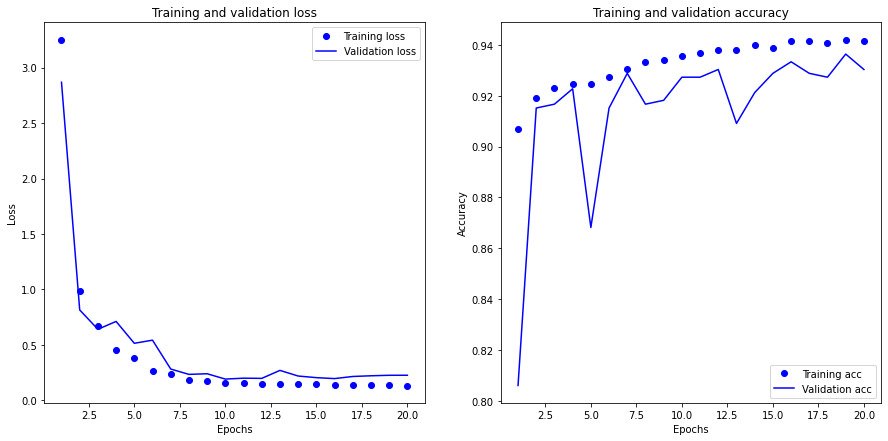

In [212]:
visualize_training(history)

In [214]:
print_test_result(model, test_x, test_y)

21/21 - 0s - loss: 0.2633 - accuracy: 0.9333
loss: 0.263
accuracy: 0.933
